In [102]:
"""

PROD ALERT 2 CODE

Copyright © 2023 Dr Keith S Reid Cailleach Computing Ltd

keithreid@nhs.net

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated 
documentation files (the “Software”), to deal in the Software without restriction, including without limitation 
the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and 
to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions 
of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED 
TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL 
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF 
CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER 
DEALINGS IN THE SOFTWARE.

""";

In [103]:
#       LIBRARIES

from numpy.polynomial import polynomial as P
from scipy.stats import norm

import math
import matplotlib.pyplot             as plt
import numpy                         as np
import pandas                        as pd
import warnings


In [104]:
#        CONFIGURATION SETTINGS HUMAN DECISIONS

warnings.filterwarnings('ignore')                                
pd.options.display.max_rows     = None
pd.options.display.max_columns  = None
plt.rcParams["figure.figsize"] = (10,10)

def get_reported_twice_too():
    return [3.4594316186372973, 0.0, 0.0, 
            0.0,                0.0, 0.0, 
            0.0,                0.0, 0.0, 
            3.4594316186372973, 0.0, 0.0]

def get_five_or_nothing():
    # one partial provider with about 800 bed days is excluded due to only reported 6 or 0
    # the effect to have very low variance
    return [0.0,               2.584962500721156, 2.584962500721156, 
            2.584962500721156, 2.584962500721156, 2.584962500721156, 
            2.584962500721156, 2.584962500721156, 0.0, 
            2.584962500721156, 0.0,               2.584962500721156]

def get_twothirty_or_nothing():
    # one partial provider with about 800 bed days is excluded due to only reported 6 or 0
    # the effect to have very low variance
    return [0.0,               0.0,               0.0, 
            0.0,               0.0,               7.851749041416057, 
            7.851749041416057, 7.851749041416057, 7.6865005271832185, 
            0.0,               0.0,               7.539158811108031]
    
def get_reported_restraint_twice():
    # one provider was excluded from funnel plot for sect vs rstr
    # funnel plot for sect vs rstr is more sensitive to gaps in both rstr and sect
    # due to only reporting restraint twice
    # this made them seem very consistent
    # it gave them huge precision of 9679688.492560597
    return [0.0,               0.0,               0.0, 
            0.0,               0.0,               0.0, 
            0.0,               0.0,               2.584962500721156, 
            0.0,               2.584962500721156, 0.0]
    

def get_small_for_rstr():
    # smallness is handled as a configuration because it is based on a judgement
    get_small_for_rstr = ["SCHOEN CLINIC YORK",
                        "GREAT ORMOND STREET HOSPITAL FOR CHILDREN NHS FOUNDATION TRUST",
                        "ALDER HEY CHILDREN'S NHS FOUNDATION TRUST",
                        "TURNING POINT",
                        "NEWMARKET HOUSE HEALTHCARE LTD",
                        "WHITTINGTON HEALTH NHS TRUST",
                        "MANCHESTER UNIVERSITY NHS FOUNDATION TRUST",
                        "NORTHUMBRIA HEALTHCARE NHS FOUNDATION TRUST",
                        "NEWBRIDGE CARE SYSTEMS LTD",
                        "BRAMLEY HEALTH",
                        "REGIS HEALTHCARE LIMITED",
                        "RIVERDALE GRANGE LIMITED",
                        "SHEFFIELD CHILDREN'S NHS FOUNDATION TRUST"]
    return get_small_for_rstr

def get_small_for_sect():
    # smallness is handled as a configuration because it is based on a judgement
    small_for_sect = ["SCHOEN CLINIC YORK",
                        "GREAT ORMOND STREET HOSPITAL FOR CHILDREN NHS FOUNDATION TRUST",
                        "ALDER HEY CHILDREN'S NHS FOUNDATION TRUST",
                        "TURNING POINT",
                        "NEWMARKET HOUSE HEALTHCARE LTD",
                        "WHITTINGTON HEALTH NHS TRUST",
                        "MANCHESTER UNIVERSITY NHS FOUNDATION TRUST",
                        "NORTHUMBRIA HEALTHCARE NHS FOUNDATION TRUST",
                        "NEWBRIDGE CARE SYSTEMS LTD",
                        "BRAMLEY HEALTH",
                        "REGIS HEALTHCARE LIMITED",
                        "RIVERDALE GRANGE LIMITED",
                        "SHEFFIELD CHILDREN'S NHS FOUNDATION TRUST",
                        "EQUILIBRIUM HEALTHCARE",
                        "BIRMINGHAM WOMEN'S AND CHILDREN'S NHS FOUNDATION TRUST",
                        "DERBYSHIRE COMMUNITY HEALTH SERVICES NHS FOUNDATION TRUST",
                        "ACTIVE PATHWAYS",
                        "NEWBRIDGE CARE SYSTEMS",
                        "MAKING SPACE",
                        "ELLERN MEDE BARNET",
                        "CARETECH COMMUNITY SERVICES (NO.2) LIMITED",
                        "ISLE OF WIGHT NHS TRUST"]
    return small_for_sect

def get_verbose():
    verbose = "No" # "Yes" or "No"
    return verbose

In [105]:
#       GET DATA FROM CSV FILES WHICH BEEN CLEANED PER MANUAL

def get_beds_files():
    beds_files = ["beds01_Sep_2021.csv", "beds02_Oct_2021.csv", "beds03_Nov_2021.csv",
                  "beds04_Dec_2021.csv", "beds05_Jan_2022.csv", "beds06_Feb_2022.csv",
                  "beds07_Mar_2022.csv", "beds08_Apr_2022.csv", "beds09_May_2022.csv",
                  "beds10_Jun_2022.csv", "beds11_Jul_2022.csv", "beds12_Aug_2022.csv"]
    return beds_files

def get_providers():
    beds_files              = get_beds_files()
    names_with_some_beds    = []
    for this_file in beds_files:
        df          = pd.read_csv(this_file, header=None)
        df.columns  = ["Month","Provider","Metric","Count"]
        for index, row in df.iterrows():
            if row["Count"] != "*":
                names_with_some_beds.append(row["Provider"])
    providers   = sorted(list(set(names_with_some_beds)))
    return providers

def get_rstr_files():
    rstr_files = ["rstr01_Sep_2021.csv", "rstr02_Oct_2021.csv", "rstr03_Nov_2021.csv",
                  "rstr04_Dec_2021.csv", "rstr05_Jan_2022.csv", "rstr06_Feb_2022.csv",
                  "rstr07_Mar_2022.csv", "rstr08_Apr_2022.csv", "rstr09_May_2022.csv",
                  "rstr10_Jun_2022.csv", "rstr11_Jul_2022.csv", "rstr12_Aug_2022.csv"]
    return rstr_files

def get_sect_files():
    rstr_files = ["sect01_Sep_2021.csv", "sect02_Oct_2021.csv", "sect03_Nov_2021.csv",
                  "sect04_Dec_2021.csv", "sect05_Jan_2022.csv", "sect06_Feb_2022.csv",
                  "sect07_Mar_2022.csv", "sect08_Apr_2022.csv", "sect09_May_2022.csv",
                  "sect10_Jun_2022.csv", "sect11_Jul_2022.csv", "sect12_Aug_2022.csv"]
    return rstr_files

In [106]:
#       BUILD TABLES

def analyse_provider_residuals(log_main):
    classified_providers                = classify_providers(log_main)
    best_c, best_m                      = count_cm(classified_providers)
    each_predicted_restraint            = (classified_providers["LogSect"]*best_m)+best_c
    each_residual                       = classified_providers["LogRstr"] - each_predicted_restraint
    classified_providers["Predicted"]   = each_predicted_restraint
    classified_providers["Residual"]    = each_residual
    return classified_providers, best_c

def build_log_main():
    # read the underlying csvs and associate those numbers with attributes
    providers               = get_providers()
    monthly_providers_beds  = build_monthly_providers_beds(providers)
    monthly_providers_rstr  = build_monthly_providers_rstr(providers)
    monthly_providers_sect  = build_monthly_providers_sect(providers)
                             
    # put them together in order and log transform to handle scale
    ordered_providers   = order_providers_by_size(monthly_providers_beds)
    ordered_beds        = pd.concat([ordered_providers,monthly_providers_beds], axis=1).reindex(ordered_providers.index)
    and_sect            = pd.concat([ordered_beds,monthly_providers_sect], axis=1).reindex(ordered_beds.index)
    and_rstr            = pd.concat([and_sect,monthly_providers_rstr], axis=1).reindex(and_sect.index)
    log_main            = laplace_correction_and_log(and_rstr)
    return log_main

def build_monthly_providers_beds(providers):
    beds_files              = get_beds_files()
    months                  = [x[0:10] for x in beds_files]
    monthly_providers_beds  = pd.DataFrame(columns = months, index = providers)
    for this_file in beds_files:
        month                       = this_file[0:10]
        monthly_bed_info            = pd.read_csv(this_file, header=None)
        monthly_bed_info.columns    = ["Month","Provider","Metric","Count"]
        for index, row in monthly_bed_info.iterrows():
            if row["Provider"] in providers:
                monthly_providers_beds.at[row["Provider"], month] = row["Count"]
                
    monthly_providers_beds.replace("*",   "0", inplace=True)
    monthly_providers_beds.fillna("0", inplace=True)
    return monthly_providers_beds

def build_monthly_providers_rstr(providers):
    rstr_files              = get_rstr_files()
    months                  = [x[0:10] for x in rstr_files]
    monthly_providers_rstr  = pd.DataFrame(columns = months, index = providers)
    for this_file in rstr_files:
        month                       = this_file[0:10]
        monthly_rstr_info            = pd.read_csv(this_file, header=None)
        monthly_rstr_info.columns    = ["Month","Provider","Metric","Count"]
        for index, row in monthly_rstr_info.iterrows():
            if row["Provider"] in providers:
                monthly_providers_rstr.at[row["Provider"], month] = row["Count"]
    monthly_providers_rstr.replace("*",   "0", inplace=True)
    monthly_providers_rstr.fillna("0", inplace=True)
    return monthly_providers_rstr

def build_monthly_providers_sect(providers):
    # kept this in the beds rstr version
    sect_files              = get_sect_files()
    months                  = [x[0:10] for x in sect_files]
    monthly_providers_sect  = pd.DataFrame(columns = months, index = providers)
    for this_file in sect_files:
        month                       = this_file[0:10]
        monthly_sect_info            = pd.read_csv(this_file, header=None)
        monthly_sect_info.columns    = ["Month","Provider","Metric","Count"]
        for index, row in monthly_sect_info.iterrows():
            if row["Provider"] in providers:
                monthly_providers_sect.at[row["Provider"], month] = row["Count"]
    monthly_providers_sect.replace("*",   "0", inplace=True)
    monthly_providers_sect.fillna("0", inplace=True)
    return monthly_providers_sect

In [119]:
#       MATHS MODEL

def count_bounds(classified_providers, best_c):
    complete_boolean            = [x in("FULL", "CLOSE") for x in classified_providers["Style"]]
    complete_rows               = classified_providers[complete_boolean]
    complete_residuals          = complete_rows["Residual"]
    complete_residuals_std_dev  = complete_residuals.std()
    complete_residuals_mean     = complete_residuals.mean()
    complete_LogRstr_minus_c    = complete_rows["LogRstr"] - best_c 
    complete_rows["Slopes"]     = complete_LogRstr_minus_c/complete_rows["LogSect"]
    complete_slope_mean         = complete_rows["Slopes"].mean()
    complete_slope_std_dev      = complete_rows["Slopes"].std()
    slope_two_sigma             = 2 * complete_slope_std_dev
    lower_bound_slope           = complete_slope_mean -slope_two_sigma
    upper_bound_slope           = complete_slope_mean + slope_two_sigma
    classified_providers["Lower"] = best_c + (lower_bound_slope * 
                                              classified_providers["LogSect"])
    classified_providers["Upper"] = best_c + (upper_bound_slope * 
                                              classified_providers["LogSect"])
    distro_package              = complete_residuals,complete_residuals_mean,complete_residuals_std_dev
    return classified_providers, distro_package

def count_cm(df_sect_rstr):
    # derive m nand c 
    # for y = mx+c
    boolean_complete_rows   = [x in("FULL") for x in df_sect_rstr["Style"]]
    complete_rows           = df_sect_rstr[boolean_complete_rows]
    
    boolean_not_NaN_rows    = [not np.isnan(x) for x in complete_rows["LogSect"]]
    complete_not_NaN        = complete_rows[boolean_not_NaN_rows]
    
    print("We had to get rid of a complete restraint reporter which reported no detentions at all.")
    
    best_c, best_m          = P.polyfit(complete_not_NaN["LogSect"],complete_not_NaN["LogRstr"],1,full=False)
    return best_c, best_m

def classify_providers(log_main):
        """
        This is the categorisation logic
        based on PROD-ALERT 1 published methods

        For PROD_ALERT-2
        Small?
            Yes -> "SMALL" ---------------> SMALL and (NO RESTRAINTS and (PARTIAL or JOINER bed-days))?
            No  -> Full?                        Yes -> "NULL"
                Yes -> "FULL"                   No  -> "SMALL"
                No  -> drops one?
                    Yes -> "CLOSE"
                    No  -> Joins?
                        Yes -> "JOINS"
                        No  -> "PARTIAL"

        """
        small_for_sect  = get_small_for_sect()
        names_sect_rstr = []
        for index, row in log_main.iterrows():
            reported_sect = [row["sect01_Sep"], row["sect02_Oct"], row["sect03_Nov"],
                             row["sect04_Dec"], row["sect05_Jan"], row["sect06_Feb"],
                             row["sect07_Mar"], row["sect08_Apr"], row["sect09_May"],
                             row["sect10_Jun"], row["sect11_Jul"], row["sect12_Aug"]]
            reported_rstr = [row["rstr01_Sep"], row["rstr02_Oct"], row["rstr03_Nov"],
                             row["rstr04_Dec"], row["rstr05_Jan"], row["rstr06_Feb"],
                             row["rstr07_Mar"], row["rstr08_Apr"], row["rstr09_May"],
                             row["rstr10_Jun"], row["rstr11_Jul"], row["rstr12_Aug"]]
            
            override_for_partial_joiner_beds = ["SCHOEN CLINIC YORK","TURNING POINT",
                                                "MANCHESTER UNIVERSITY NHS FOUNDATION TRUST",
                                                "NEWBRIDGE CARE SYSTEMS LTD","REGIS HEALTHCARE LIMITED",
                                                "ELLERN MEDE BARNET","CARETECH COMMUNITY SERVICES (NO.2) LIMITED",
                                                "JOHN MUNROE HOSPITAL","THE HUNTERCOMBE GROUP"]
            clean_sect      = [x for x in reported_sect if x>0]
            clean_rstr      = [x for x in reported_rstr if x>0]
            mean_sect       = np.mean(clean_sect)
            mean_rstr       = np.mean(clean_rstr)
            if index in small_for_sect:
                if index in override_for_partial_joiner_beds:
                    mean_rstr       = 0.0
                    sect_rstr_point = ["NULL", mean_sect, mean_rstr] #index
                else:
                    if math.isnan(mean_rstr):
                        mean_rstr       = 0.0
                        sect_rstr_point = ["SMALL", mean_sect, mean_rstr] #index
                names_sect_rstr.append(sect_rstr_point)
            else:
                if reported_rstr == [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]:
                    if index not in small_for_sect:
                        mean_rstr       = 0.0
                        sect_rstr_point = ["NULL", mean_sect, mean_rstr] #index
                        names_sect_rstr.append(sect_rstr_point)
                else:
                    if [x>0 for x in reported_rstr] == [True, True, True, True, True, True, True, True, True, True, True, True,]:
                        sect_rstr_point = ["FULL", mean_sect, mean_rstr] #index
                        names_sect_rstr.append(sect_rstr_point)
                    else:
                        if sum([int(y) for y in [x>0 for x in reported_rstr]]) == 11:
                            sect_rstr_point = ["CLOSE", mean_sect, mean_rstr] #index
                            names_sect_rstr.append(sect_rstr_point)
                        else:
                            if [[x>0 for x in reported_rstr][i-1]<=[x>0 for x in reported_rstr][i]
                                for i in list(range(1,12))] == [True, True, True, True, 
                                                                 True, True, True, True,
                                                                  True, True, True]:
                                sect_rstr_point = ["JOINS", mean_sect, mean_rstr] #index
                                names_sect_rstr.append(sect_rstr_point)
                            else:
                                sect_rstr_point = ["PARTIAL", mean_sect, mean_rstr] #index
                                names_sect_rstr.append(sect_rstr_point)
        classifed_providers         = pd.DataFrame(names_sect_rstr)
        classifed_providers.columns = ["Style","LogSect", "LogRstr"] 
        return classifed_providers

def laplace_correction_and_log(main_table):
    main_table  = main_table.astype(int)
    log_main    = main_table.transform(lambda x: np.log2(x+1))
    return log_main

def order_providers_by_size(monthly_providers_beds):
        # returns NaN for all 0 but none should have that
        # no test - fell out of writing a higher function
        providers_by_size               = monthly_providers_beds.copy()
        providers_by_size               = providers_by_size.astype(int)
        providers_by_size["ProperMean"] = providers_by_size.mask(providers_by_size==0).mean(axis=1)
        providers_by_size               = providers_by_size.sort_values(by="ProperMean")
        providers_by_size               = providers_by_size.sort_values(by="ProperMean")
        providers_by_size.drop(["beds01_Sep","beds02_Oct","beds03_Nov",
                                "beds04_Dec","beds05_Jan","beds06_Feb",
                                "beds07_Mar","beds08_Apr","beds09_May",
                                "beds10_Jun","beds11_Jul","beds12_Aug"], axis=1, inplace=True)
        return providers_by_size
    
def predict_incomplete(classified_providers):
    incomplete_boolean    = [x in("NULL", "PARTIAL", "JOINER") for x in classified_providers["Style"]]
    incomplete_rows       = classified_providers[incomplete_boolean]
    incomplete_rows["RebasedPredictions"]   = [2**x for x in incomplete_rows["Predicted"]]
    incomplete_rows["RebasedLowers"]        = [2**x for x in incomplete_rows["Lower"]]
    incomplete_rows["RebasedUppers"]        = [2**x for x in incomplete_rows["Upper"]]
    incomplete_rep_sum  = sum(incomplete_rows["RebasedPredictions"])
    incomplete_rep_low  = sum(incomplete_rows["RebasedLowers"])
    incomplete_rep_high = sum(incomplete_rows["RebasedUppers"])
    unheard_package     = incomplete_rep_sum, incomplete_rep_low, incomplete_rep_high
    return unheard_package

In [120]:
#       VIEW

def draw_distro_of_complete_residuals(distro_package):
    
    complete_residuals, complete_residuals_mean, complete_residuals_std_dev = distro_package
    print("We suppose COMPLETE reports give the best trend.")
    print("This plot shows the (neat, useful, reliable) distribution of slopes in complete reporters.")
    print("This was the method in the peer reviewed paper PROD-ALERT 1.")
    print("It was supported by the true figures from large joining providers.")
    print("The distribution (shape of spread) of the residuals for COMPLETE reporters is normal.")
    print("That normal distribution supports correlation.")
    print("We made this graph by superimposing histograms with different bin sizes.")
    print("Note the COMPLETE RESIDUAL mean is small.")
    print("It is small because COMPLETE reporters being reliable stick to the trend which is based on COMPLETE reporters.")
    print("\nMean residual of COMPLETE reports restraint/detention trend:\t\t", complete_residuals_mean)
    print("Standard deviation of COMPLETE reports restraint/detention trend:\t", complete_residuals_std_dev)
    print("In summary this plot helps us see the trend among COMPLETE reports as reliable.")
    x = np.arange(-3,3,0.05)
    plt.plot(x, 16*norm.pdf(x, complete_residuals_mean, complete_residuals_std_dev))
    for i in range (5,23):
        complete_residuals.hist(bins=i, alpha=0.2,color="grey")
    
def draw_funnel(classified_providers):
    print("\n\nThis funnel plot uses the variance of the estimation of log restraints per log detention.")
    print("Each dot is an provider's estimate of log restraint against log detentions.")
    print("Higher dots are more precise, less variable between months exclusing zeros.")
    print("For this we can only use months where both detentions and restraint are reported.")    
    print("The position left-right is the estimate.")
    print("We must ignore NULLS and SMALLs because neither has any such month.")
    print("A symmetrical triangular shape would reassure us that spread left to right is not due to precision.")
    print("This graph has a big hole in the right hand side as did PROD-ALERT.")
    print("The blue guide lines are indicative and hand-plotted.")
    print("Precision interacts with estimates: one cause of this is bias.")
    print("A fuller discussion is given in PROD-ALERT 1.")
    full_boolean    = [x in("FULL") for x in classified_providers["Style"]]
    for index, row in log_main[full_boolean].iterrows():
        reported_sect = [row["sect01_Sep"], row["sect02_Oct"], row["sect03_Nov"],
                         row["sect04_Dec"], row["sect05_Jan"], row["sect06_Feb"],
                         row["sect07_Mar"], row["sect08_Apr"], row["sect09_May"],
                         row["sect10_Jun"], row["sect11_Jul"], row["sect12_Aug"]]
        reported_rstr = [row["rstr01_Sep"], row["rstr02_Oct"], row["rstr03_Nov"],
                         row["rstr04_Dec"], row["rstr05_Jan"], row["rstr06_Feb"],
                         row["rstr07_Mar"], row["rstr08_Apr"], row["rstr09_May"],
                         row["rstr10_Jun"], row["rstr11_Jul"], row["rstr12_Aug"]]
        both          = list(zip(reported_rstr, reported_sect))
        ratios        = [x[0]/x[1] for x in both if (x[0]>0 and x[1]>0)]
        precision     = 1/np.var(ratios)
        mean          = np.mean(ratios)
        plt.scatter(mean, precision, color = "blue", s=200, alpha=0.5)
    close_boolean    = [x in("CLOSE") for x in classified_providers["Style"]]
    for index, row in log_main[close_boolean].iterrows():
        reported_sect = [row["sect01_Sep"], row["sect02_Oct"], row["sect03_Nov"],
                         row["sect04_Dec"], row["sect05_Jan"], row["sect06_Feb"],
                         row["sect07_Mar"], row["sect08_Apr"], row["sect09_May"],
                         row["sect10_Jun"], row["sect11_Jul"], row["sect12_Aug"]]
        reported_rstr = [row["rstr01_Sep"], row["rstr02_Oct"], row["rstr03_Nov"],
                         row["rstr04_Dec"], row["rstr05_Jan"], row["rstr06_Feb"],
                         row["rstr07_Mar"], row["rstr08_Apr"], row["rstr09_May"],
                         row["rstr10_Jun"], row["rstr11_Jul"], row["rstr12_Aug"]]
        both          = list(zip(reported_rstr, reported_sect))
        ratios        = [x[0]/x[1] for x in both if (x[0]>0 and x[1]>0)]
        precision     = 1/np.var(ratios)
        mean          = np.mean(ratios)
        plt.scatter(mean, precision, facecolor="cyan", edgecolor="blue", alpha=0.5, 
                            s=200)
    partial_boolean    = [x in("PARTIAL") for x in classified_providers["Style"]]
    for index, row in log_main[partial_boolean].iterrows():
        
        reported_sect = [row["sect01_Sep"], row["sect02_Oct"], row["sect03_Nov"],
                         row["sect04_Dec"], row["sect05_Jan"], row["sect06_Feb"],
                         row["sect07_Mar"], row["sect08_Apr"], row["sect09_May"],
                         row["sect10_Jun"], row["sect11_Jul"], row["sect12_Aug"]]
        reported_rstr = [row["rstr01_Sep"], row["rstr02_Oct"], row["rstr03_Nov"],
                         row["rstr04_Dec"], row["rstr05_Jan"], row["rstr06_Feb"],
                         row["rstr07_Mar"], row["rstr08_Apr"], row["rstr09_May"],
                         row["rstr10_Jun"], row["rstr11_Jul"], row["rstr12_Aug"]]
        
        both          = list(zip(reported_rstr, reported_sect))
        ratios        = [x[0]/x[1] for x in both if (x[0]>0 and x[1]>0)]
        precision     = 1/np.var(ratios)
        mean          = np.mean(ratios)                       
        
        five_or_nothing             = get_five_or_nothing()
        twothirty_or_nothing        = get_twothirty_or_nothing()
        reported_restraint_twice    = get_reported_restraint_twice()
        reported_twice_too          = get_reported_twice_too()
        
        obivous_outliers_with_reasons = (five_or_nothing,          twothirty_or_nothing, 
                                         reported_restraint_twice, reported_twice_too)
        
        if (reported_rstr not in obivous_outliers_with_reasons):
            plt.scatter(mean, precision, color="grey", alpha=0.5, s=200)
    joins_boolean    = [x in("JOINS") for x in classified_providers["Style"]]
    for index, row in log_main[joins_boolean].iterrows():
        reported_sect = [row["sect01_Sep"], row["sect02_Oct"], row["sect03_Nov"],
                         row["sect04_Dec"], row["sect05_Jan"], row["sect06_Feb"],
                         row["sect07_Mar"], row["sect08_Apr"], row["sect09_May"],
                         row["sect10_Jun"], row["sect11_Jul"], row["sect12_Aug"]]
        reported_rstr = [row["rstr01_Sep"], row["rstr02_Oct"], row["rstr03_Nov"],
                         row["rstr04_Dec"], row["rstr05_Jan"], row["rstr06_Feb"],
                         row["rstr07_Mar"], row["rstr08_Apr"], row["rstr09_May"],
                         row["rstr10_Jun"], row["rstr11_Jul"], row["rstr12_Aug"]]
        both          = list(zip(reported_rstr, reported_sect))
        ratios        = [x[0]/x[1] for x in both if (x[0]>0 and x[1]>0)]
        precision     = 1/np.var(ratios)
        mean          = np.mean(ratios)
        plt.scatter(mean, precision, facecolor="white", edgecolor="black", s=200, alpha=0.5)
    plt.plot([0.48,0.78,1.08],[0,6000,0])
    plt.plot([0.78,0.78],[0,6000],color="blue",linestyle="dashed")
    
def greet():
    print("""Welcome to PROD ALERT 2. These results have not been peer reviewed.
They are shown so that the development can be described as having been done openly, 
in retrospect, later. Underlying figures are already available at NHS Digital.
     """)
        
def scatter_classifieds(classified_providers):
    print("\nThis scatter plot and regression analysis correlates detention with restraint.")
    print("Specifically it correlates persons restrained per month with detaiened persons per month.")
    print("It uses proper averages taken from the whole year of reports for two government metrics.")
    print("Allowing for size due to Laplace it adds one to all values plots their power of two not their absoulate value.")
    is_small        = [x in("SMALL") for x in classified_providers["Style"]]
    small_rows      = classified_providers[is_small]
    small_sect      = small_rows["LogSect"]
    small_rstr      = small_rows["LogRstr"]
    plt.scatter(small_sect, small_rstr, color="orange", s=200, alpha=0.5, )

    is_null        = [x in("NULL") for x in classified_providers["Style"]]
    null_rows      = classified_providers[is_null]
    null_sect      = null_rows["LogSect"]
    null_rstr      = null_rows["LogRstr"]
    plt.scatter(null_sect, null_rstr, color="black", s=200, alpha=1.0)

    is_full        = [x in("FULL") for x in classified_providers["Style"]]
    full_rows      = classified_providers[is_full]
    full_sect      = full_rows["LogSect"]
    full_rstr      = full_rows["LogRstr"]
    plt.scatter(full_sect, full_rstr, color="blue", s=200, alpha=0.5)

    is_close        = [x in("CLOSE") for x in classified_providers["Style"]]
    close_rows      = classified_providers[is_close]
    close_sect      = close_rows["LogSect"]
    close_rstr      = close_rows["LogRstr"]
    plt.scatter(close_sect, close_rstr, facecolor="cyan", edgecolor="blue", 
                    alpha=0.5, s=200)

    is_joins        = [x in("JOINS") for x in classified_providers["Style"]]
    joins_rows      = classified_providers[is_joins]
    joins_sect      = joins_rows["LogSect"]
    joins_rstr      = joins_rows["LogRstr"]
    plt.scatter(joins_sect, joins_rstr, facecolor="white", edgecolor="black", 
                    alpha=0.5, s=200)

    is_partial      = [x in("PARTIAL") for x in classified_providers["Style"]]
    partial_rows    = classified_providers[is_partial]
    partial_sect    = partial_rows["LogSect"]
    partial_rstr    = partial_rows["LogRstr"]
    class_scatter   = plt.scatter(partial_sect, partial_rstr, color ="grey", 
                    alpha=0.3, s=200)
    x               = np.arange(2,16,0.05)
    best_c, best_m  = count_cm(classified_providers)
    plt.plot(x, (best_m*x)+best_c, linestyle="dashdot")
    
def tell_unheard(unheard_package):
    incomplete_rep_sum, incomplete_rep_low, incomplete_rep_high = unheard_package
    print("\nTo conclude the size and restraint analysis we estimate people restrained per month in non-complete providers.")
    print("There is a clear and believable trend, now supported by some new joiners.")
    print("In the absence of more plausible reports we use the trend to predict restraint in NULL reporters.")
    print("Predicted people restrained per month in incomplete reporters: ", incomplete_rep_sum)
    print("Based on the spread in the complete reporters the 95% confidence is: ", incomplete_rep_low," to ", incomplete_rep_high)

Welcome to PROD ALERT 2. These results have not been peer reviewed.
They are shown so that the development can be described as having been done openly, 
in retrospect, later. Underlying figures are already available at NHS Digital.
     
We had to get rid of a complete restraint reporter which reported no detentions at all.
We suppose COMPLETE reports give the best trend.
This plot shows the (neat, useful, reliable) distribution of slopes in complete reporters.
This was the method in the peer reviewed paper PROD-ALERT 1.
It was supported by the true figures from large joining providers.
The distribution (shape of spread) of the residuals for COMPLETE reporters is normal.
That normal distribution supports correlation.
We made this graph by superimposing histograms with different bin sizes.
Note the COMPLETE RESIDUAL mean is small.
It is small because COMPLETE reporters being reliable stick to the trend which is based on COMPLETE reporters.

Mean residual of COMPLETE reports restraint/de

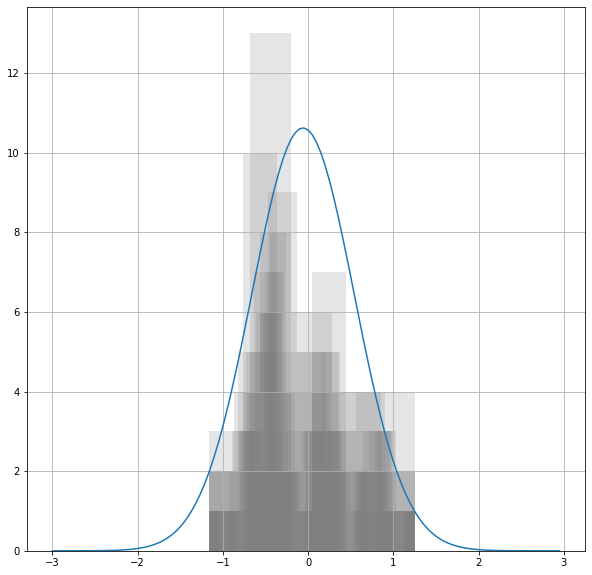



This funnel plot uses the variance of the estimation of log restraints per log detention.
Each dot is an provider's estimate of log restraint against log detentions.
Higher dots are more precise, less variable between months exclusing zeros.
For this we can only use months where both detentions and restraint are reported.
The position left-right is the estimate.
We must ignore NULLS and SMALLs because neither has any such month.
A symmetrical triangular shape would reassure us that spread left to right is not due to precision.
This graph has a big hole in the right hand side as did PROD-ALERT.
The blue guide lines are indicative and hand-plotted.
Precision interacts with estimates: one cause of this is bias.
A fuller discussion is given in PROD-ALERT 1.


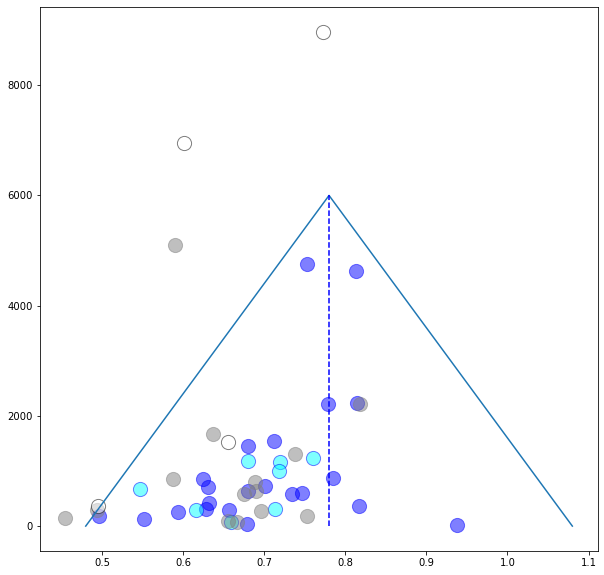


This scatter plot and regression analysis correlates detention with restraint.
Specifically it correlates persons restrained per month with detaiened persons per month.
It uses proper averages taken from the whole year of reports for two government metrics.
Allowing for size due to Laplace it adds one to all values plots their power of two not their absoulate value.
We had to get rid of a complete restraint reporter which reported no detentions at all.


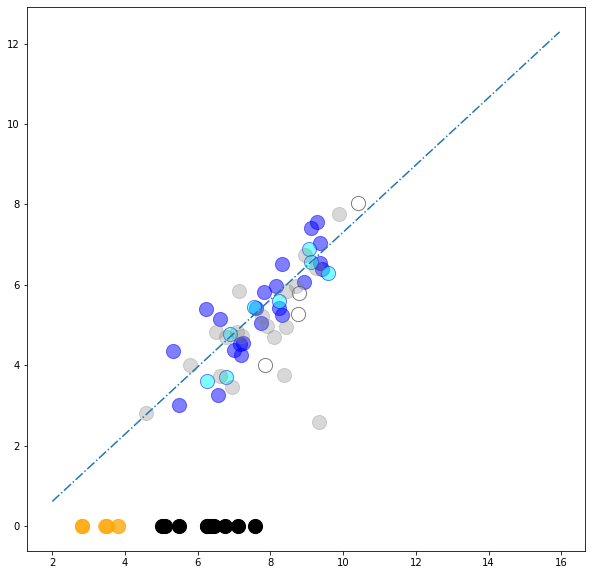


To conclude the size and restraint analysis we estimate people restrained per month in non-complete providers.
There is a clear and believable trend, now supported by some new joiners.
In the absence of more plausible reports we use the trend to predict restraint in NULL reporters.
Predicted people restrained per month in incomplete reporters:  nan
Based on the spread in the complete reporters the 95% confidence is:  nan  to  nan


In [121]:
#       CONTROL

if __name__=="__main__":
                                            
    greet()
    log_main                                = build_log_main()
    classified_providers, best_c            = analyse_provider_residuals(log_main)
    classified_providers, distro_package    = count_bounds(classified_providers, best_c)
    unheard_package                         = predict_incomplete(classified_providers)
    
    distro          = draw_distro_of_complete_residuals(distro_package)
    plt.show(distro)
    funnel          = draw_funnel(classified_providers)
    plt.show(funnel)
    scatter_plot    = scatter_classifieds(classified_providers)
    plt.show(scatter_plot)
    # violence is the language of the unheard: Rev Dr Martin Luther King III
    #@misc{also_cited_by_huckshorn,
    #  author       = "Martin Luther King",
    #  title        = "The Other America",
    #  howpublished = "\url{https://the-other-america.com/speech}",
    #  month        = "March",
    #  year         = "1968",
    #  note         = "Accessed: 26th Oct 2022",
    #}
    tell_unheard(unheard_package)
    

In [110]:
#       TEST - WE RECOMMEND TEST DRIVEN DEVELOPMENT

def test_build_monthly_providers_beds():
    providers              = get_providers()
    monthly_providers_beds = build_monthly_providers_beds(providers)
    assert type(monthly_providers_beds)    == pd.DataFrame, "type test"
    assert type(monthly_providers_beds["beds01_Sep"]) == pd.Series, "type test"
    assert monthly_providers_beds.at["WEST LONDON NHS TRUST","beds01_Sep"] == "19235", "correct value and type"
    assert monthly_providers_beds.at["WEST LONDON NHS TRUST","beds01_Sep"] != 19235,   "correct value and type"
    assert monthly_providers_beds.at["WEST LONDON NHS TRUST","beds01_Sep"] != "999",   "correct value and type"
    assert len(monthly_providers_beds)     == len(set(providers)), "uniqueness test"
    assert monthly_providers_beds.index[1] == providers[1], "matches providers test"
    print("passed build monthly providers beds")
    
def test_build_monthly_providers_rstr():
    providers              = get_providers()
    monthly_providers_rstr = build_monthly_providers_rstr(providers)
    assert type(monthly_providers_rstr)    == pd.DataFrame, "type test"
    assert type(monthly_providers_rstr["rstr01_Sep"]) == pd.Series, "type test"
    assert monthly_providers_rstr.at["WEST LONDON NHS TRUST","rstr01_Sep"] == "75", "correct value and type"
    assert monthly_providers_rstr.at["WEST LONDON NHS TRUST","rstr01_Sep"] != 75,   "correct value and type"
    assert monthly_providers_rstr.at["WEST LONDON NHS TRUST","rstr01_Sep"] != "999","correct value and type"  
    assert len(monthly_providers_rstr)     == len(set(providers)), "uniqueness test"
    assert monthly_providers_rstr.index[1] == providers[1], "matches providers test"
    print("passed build monthly providers rstr")
    
def test_build_monthly_providers_sect():
    providers              = get_providers()
    monthly_providers_sect = build_monthly_providers_sect(providers)
    assert type(monthly_providers_sect)    == pd.DataFrame, "type test"
    assert type(monthly_providers_sect["sect01_Sep"]) == pd.Series, "type test"
    assert monthly_providers_sect.at["WEST LONDON NHS TRUST","sect01_Sep"] == "565", "correct value and type"
    assert monthly_providers_sect.at["WEST LONDON NHS TRUST","sect01_Sep"] != 565,   "correct value and type"
    assert monthly_providers_sect.at["WEST LONDON NHS TRUST","sect01_Sep"] != "999","correct value and type"  
    assert len(monthly_providers_sect)     == len(set(providers)), "uniqueness test"
    assert monthly_providers_sect.index[1] == providers[1], "matches providers test"
    print("passed build monthly providers sect")
    
def test_get_providers():
    providers = get_providers()
    assert type(providers)    == list, "type test"
    assert type(providers[1]) == str, "type test"
    assert len(providers)  == len(set(providers)), "uniqueness test"
    print("passed get providers")
    
def test_laplace_correction_and_log():
    toy         = {'Number':[4,3,2,1]}
    toy_df      = pd.DataFrame(toy)
    log_main    = laplace_correction_and_log(toy_df)
    assert list(log_main.Number) == [2.321928094887362, 2.0, 1.584962500721156, 1.0]    
    toy         = {'Jam':[4,3,2,1],'Spam':[15,31,63,0]}
    toy_df      = pd.DataFrame(toy)
    log_main    = laplace_correction_and_log(toy_df)
    assert list(log_main.Jam)  == [2.321928094887362, 2.0, 1.584962500721156, 1.0]
    assert list(log_main.Spam) == [4.0, 5.0, 6.0, 0.0]
    print("passed laplace correction and log")

def all_tests():
    test_build_monthly_providers_beds()
    test_build_monthly_providers_rstr()
    test_build_monthly_providers_sect()  
    test_get_providers()
    test_laplace_correction_and_log()
    print("passed all tests")
    
all_tests()    

passed build monthly providers beds
passed build monthly providers rstr
passed build monthly providers sect
passed get providers
passed laplace correction and log
passed all tests


In [111]:
"""
NOTES:

The author can provide sensitivity models, upon reasonable request.
Preferably readers may do their own, and can fork the code here.
The list of provders in caps is a list of those who could have zero due to size.


     SHEFFIELD CHILDREN'S NHS FOUNDATION TRUST average size 490.833333

beds 450 	510 	490 	480 	445 	450 	530 	525 	480 	510 	515 	505 
sect 10  	10  	10  	10  	10  	10  	10  	5   	10  	10  	10  	5


     EQUILIBRIUM HEALTHCARE                    average size 527.916667
     
beds 600 	650 	630 	650 	650 	500 	470 	450 	465 	435 	435 	400 
sect 20    	20  	20  	20  	20  	15  	15  	15  	15  	15  	15  	10

Due to visual inpection small for detentions is set at effectively 500.

These are small for detentions:

SCHOEN CLINIC YORK
GREAT ORMOND STREET HOSPITAL FOR CHILDREN NHS FOUNDATION TRUST
ALDER HEY CHILDREN'S NHS FOUNDATION TRUST
TURNING POINT
NEWMARKET HOUSE HEALTHCARE LTD
WHITTINGTON HEALTH NHS TRUST
MANCHESTER UNIVERSITY NHS FOUNDATION TRUST
NORTHUMBRIA HEALTHCARE NHS FOUNDATION TRUST
NEWBRIDGE CARE SYSTEMS LTD
BRAMLEY HEALTH
REGIS HEALTHCARE LIMITED
RIVERDALE GRANGE LIMITED
SHEFFIELD CHILDREN'S NHS FOUNDATION TRUST



Due to visual inspection small for restraint is set at effectively 1011.

     ISLE OF WIGHT NHS TRUST                    average size 1011.250000
     
beds 990 	995 	1090 	1145 	1185 	920 	1075 	905 	1000 	915 	980 	935
sect 20  	30  	25  	25  	30  	30  	25  	30  	35  	20  	20  	20
rstr 5   	15  	15  	15  	15  	20  	20  	15  	15  	15  	10  	10

These are small for restraints:

SCHOEN CLINIC YORK
GREAT ORMOND STREET HOSPITAL FOR CHILDREN NHS FOUNDATION TRUST
ALDER HEY CHILDREN'S NHS FOUNDATION TRUST
TURNING POINT
NEWMARKET HOUSE HEALTHCARE LTD
WHITTINGTON HEALTH NHS TRUST
MANCHESTER UNIVERSITY NHS FOUNDATION TRUST
NORTHUMBRIA HEALTHCARE NHS FOUNDATION TRUST
NEWBRIDGE CARE SYSTEMS LTD
BRAMLEY HEALTH
REGIS HEALTHCARE LIMITED
RIVERDALE GRANGE LIMITED
SHEFFIELD CHILDREN'S NHS FOUNDATION TRUST
EQUILIBRIUM HEALTHCARE
BIRMINGHAM WOMEN'S AND CHILDREN'S NHS FOUNDATION TRUST
DERBYSHIRE COMMUNITY HEALTH SERVICES NHS FOUNDATION TRUST
ACTIVE PATHWAYS
NEWBRIDGE CARE SYSTEMS
MAKING SPACE
ELLERN MEDE BARNET
CARETECH COMMUNITY SERVICES (NO.2) LIMITED
ISLE OF WIGHT NHS TRUST

""";